# Lab 4.2: Random Forests

Following on from Lab 4.1: Decision trees, the Random Forest algorithm is based on Decisions Trees and can be used for either regression or classification tasks. To overcome Decisions Trees tendancy to overfit, Random Foreasts aggregate the results from many decision trees with an [ensemble approach](http://scikit-learn.org/stable/modules/ensemble.html). 

In this lesson we focus on Random Forests, which use bagging to prevent overfitting by only allowing a given decision tree to optimize for a random subset of the data for every tree, and a random subset of the input features at every split. (Don't worry if this does not make too much sense right now, we'll work through together  😀). 

Here's a look ahead at what we'll be doing in this notebook:

1. [Import packages](#packages)
2. [Load data](#loaddata)
3. [Bagging](#bagging)
4. [Build a Random Forest](#randomforest)
5. [Tune parameters](#parameters)
6. [Feature importance](#featureimportance)
7. [Homework](#homework)


A quick refresher on Bagging:
- Grow multiple decisions trees from random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!

Again, we will be looking at how we can predict the loan amount using the random forest algorithm. 

Here is a very [simple example](https://bicorner.com/2015/10/26/random-forest-using-ipython/) of how the RandomForestClassifier works: 

## 1. Import packages
<a id='loaddata'></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

## 2. Load and format data
<a id='loaddata'></a>

In [2]:
# Load data to pandas DataFrame
import pandas as pd
data_path = '../data/'
df = pd.read_csv(data_path+'clean_data.csv.zip', 
                 low_memory=False) 

In [3]:
# TODO: Need to explain why we are only considering a subset of the columns
cols = df[['loan_amount', 
           'partner_delinquency_rate',
            'posted_year',
           'posted_month',
           'female',
           'num_tags',
           'parent',
           '#Woman Owned Biz',
           'age_int',
           '#Repeat Borrower',
           'children_int',
          'terms.repayment_term',
           '#Schooling',
           'married',
           'pct_female',
           'exploratory_partner',
           'partner_dollar_amount',
           'top_partner_id',
           'days_to_fund']]

In [4]:
y = df['loan_amount']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('loan_amount', axis=1)

In [5]:
# Split data into training and testing sets;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Bagging
<a id='bagging'></a>

As Decision Trees naturally overfit to the data, better performance is achieved when an **ensemble approach** such as Bagging is used.

Bagging is a shorter term for Bootstrapping Aggregation which is a general procedure to reduce variance in models that have a tendancy to overfit.

This diagram below gives a visual overview of how bagging works in the context of a classifying algorithm.

<img src="../images/bagging.png" alt="bagging" style="width: 500px;height=500"/>

As an ensemble method, bagging does the following:
- Creates N random subsamples of the dataset using selection with replacement. (Statistically 1/3 of the data is left of each subsample)
- Trains a new decision tree on each N subsample
- Takes the prediction from each and every N tree and averages the result
- This average is the final output of the bagging model. 

This **Ensemble approach** uses the results of several random analyses to find an average response.

For each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or **oob_score**). This score evaluates the performance of the model on the sample not used while training an individual tree. (On average, a random ~1/3 of data are not used to train a given tree).


## 4. Build a Random Forest
<a id='randomforest'></a>

Even with Bagging, the decision trees can be largely correlated. This is because given subsets from the same dataset, the trees are probably going to split on the same features and result in very similar predictions.

To de-correlate the trees, we use a Random Forest Regressor, which at each split, only consider a random subsample of the features! This means that the trees are forced to make different split decisions and results in less correlated trees.

**A Random Forest is essentially bagged decision trees where each decision tree only considers a random subset of the features at each split**

In [6]:
# Check how many columns our dataset has...
print(f"Number of features =  {X_train.shape[1]}")
num_features = X_train.shape[1]

Number of features =  18


Recall the standard sklearn steps: 
- **Step 1: Initiate the algorithm** Define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. (Check documentation for more information)

- **Step 2: Train the algorithm** Train the algorithm by fitting it to the X_train and y_train datasets.

- **Step 3: Evaluating the algorithm** Evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

We'll use the same function we created in the previous lab to combine these into a single step with the additional option of printing the oob_score, which we should use when available.

In [7]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters,print_oob_score=False):
    '''
    Purpose: 
        - train a regressor on training data
        - score data on training and test data
        - return trained model
    '''
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    # Print the results
    print(f"Train score: {training_score:.4}")
    print(f"Test score: {testing_score:.4}")
    if print_oob_score:
        print(f"OOB score: {regressor.oob_score_:.4}")
        
    return regressor

In [8]:
num_features

18

Using the Random Forest algorithm instead of a single Decision tree introduces some new paramters that can be used to tune the model. Three new and important parameters are:
- n_estimaters = During the bagging, the number of subsamples to create and therefore the number of individual decision trees to train. 
- max_features = The maximum number of random features to consider at each split
- oob_score = whether or not to calculate the oob_score (described in bagging above)

To start we will randomly assign a value to these parameters and see how the model performs.

In [9]:
# define the parameters
parameters = {"oob_score":True, "n_estimators": 50, 
              "max_features": 10, 'random_state':42}

trained_regressor = train_score_regressor(sklearn_regressor=RandomForestRegressor,
                                          X_train=X_train, y_train=y_train, 
                                          X_test=X_test, y_test=y_test, 
                                          model_parameters=parameters,
                                          print_oob_score=True)

Train score: 0.9457
Test score: 0.6885
OOB score: 0.7025


The R^2 of the OOB score above tell us the model is performing well on unseen data. This is confirmed by the comparable R^2 for the test data. 

In [10]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    ax = sns.regplot(x=y_actual, y=y_predicted, fit_reg=False)
    ax.set_xlabel('true values')
    ax.set_ylabel('predicted values')
    ax.set_title('Relationship between true and predicted loan amounts: '+train_test+' results')
    pass

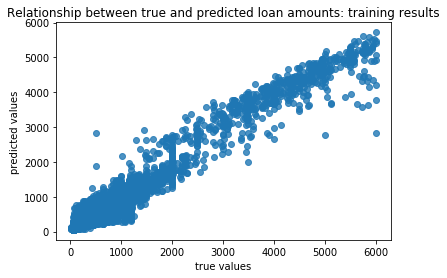

In [11]:
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test="training")

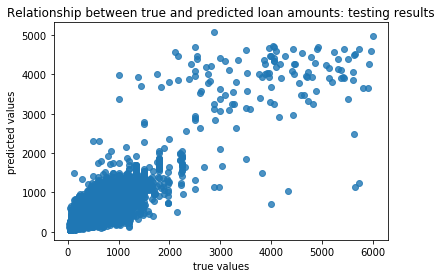

In [12]:
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test="testing")

## 5. Tune Parameters
<a id='parameters'></a>

Again, how do we know the best combination of hyperparameters? 

**Cross validated Grid Search!**

We're searching over a small range here to save time but in practice, we should search over a bigger range of hyperparameters. 

In [13]:
# define parameters
parameters = {'max_depth':[7,10,15], 
              'max_features': ['sqrt', 10, 15],
              'n_estimators': [300,400, 450]}
# initialize model
rf_regressor= RandomForestRegressor(n_jobs=-1, random_state=42)
# initialize grid search and fit
regressor = GridSearchCV(rf_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [7, 10, 15], 'max_features': ['sqrt', 10, 15], 'n_estimators': [300, 400, 450]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [14]:
# print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 10,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 450,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
# get best parameters from grid search
parameters = regressor.best_estimator_.get_params()
# set the oob_score to True. This defaulted to False in the gridsearchCV to save time
parameters['oob_score'] = True
# train and evaluate our model
trained_regressor = train_score_regressor(sklearn_regressor=RandomForestRegressor,
                                          X_train=X_train, y_train=y_train, 
                                          X_test=X_test, y_test=y_test, 
                                          model_parameters=parameters,
                                          print_oob_score=True)


Train score: 0.8325
Test score: 0.7045
OOB score: 0.7271


The best R^2 achieved with the Decision Tree algorithm alone in Lab 4.1 gave us a train and test score of 0.72 and 0.64 respectively, whereas with the Random Forest Algorithm, they have increased to 0.83 and 0.72 respectively. 

**We have see that there has been a vast improvement using the Random Forest over the Decision Tree algorithm!**

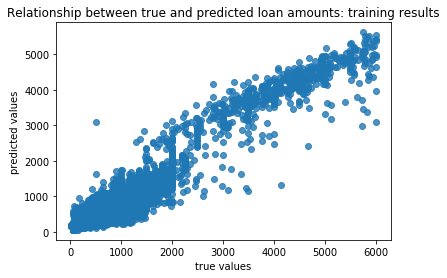

In [16]:
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test="training")

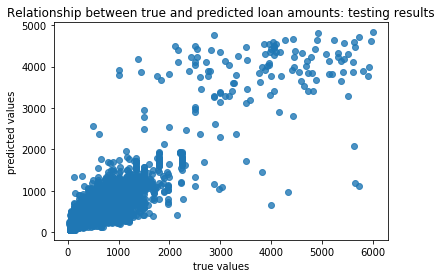

In [17]:
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test="testing")

## 6. Feature Importance
<a id='featureimportance'></a>
Remember the magnitude of the 'importance' is not indicative of how important the feature is, only the order matters!

For example,
- feature A has an importance of 0.5 
- feature B has an importance of 0.25. 

Then all we can take away is that feature A is more explains more variance then feautre B, **not** that feature A explains twice as much as feature B. 

In [18]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_

# Find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the important features in descending order
print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature partner_dollar_amount (0.157229)
2. feature days_to_fund (0.140190)
3. feature terms.repayment_term (0.138317)
4. feature exploratory_partner (0.135513)
5. feature posted_month (0.119499)
6. feature posted_year (0.081656)
7. feature partner_delinquency_rate (0.060781)
8. feature top_partner_id (0.040042)
9. feature pct_female (0.032400)
10. feature num_tags (0.031844)
11. feature age_int (0.019983)
12. feature children_int (0.014372)
13. feature #Repeat Borrower (0.006667)
14. feature married (0.006372)
15. feature female (0.005213)
16. feature parent (0.004446)
17. feature #Schooling (0.002949)
18. feature #Woman Owned Biz (0.002529)


Again, there is not a very clear relationship between any single feature and the loan_amount. The most important feature borrower count for One Acre Fund during their high loan period - this is very specific to just a small subset of the data. 

However the aggregate of these features together into the decision leads to effective predictions (R^2 ~ 0.63). This is a testament to the predictive power of Random Forests!

## 7. Homework
<a id='homework'></a>

### Predicting Days to Fund
- Repeat the DecisionTreeRegressor method with a new target feature: days_to_fund.
- Use GridSearch to tune the parameters. 
- Determine the most important features and discuss which features are intuitive or a surprise and why. 

In [19]:
y = df['days_to_fund']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('days_to_fund', axis=1)

In [20]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

In [21]:
# Use the DecisionTreeRegressor method to predict the days_to_fund
# GridSearchCV to tune parameters
# Use the model attribute important_features_ to examine the feature importance. 